<a href="https://colab.research.google.com/github/singclare/DataAnalysis/blob/master/%EB%8D%B0%ED%81%AC%EC%BA%A0_22_%EC%98%88%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive Mount, Import Library, Metadata Csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import MinMaxScaler
from PIL import Image


In [ ]:
os.getcwd()
os.chdir("/content/drive/MyDrive/데이터 공모전")

In [ ]:
path_list = []


def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file) # 경로 리턴
        if os.path.isdir(path): # 파일이 아니라 디렉토리인 경우
            print_files_in_dir(path, prefix + "    ") # 하위 파일에 대해 재실행(접두사 포함)
        else:
          ext = os.path.splitext(path)[-1] # 파일 이름, 확장자 분리
          path_list.append(path) # 위 확장자 파일인 경우 list에 추가

if __name__ == "__main__":
    root_dir = "./데이터셋/"
    print_files_in_dir(root_dir, "")

# if __name__ == "__main__" 구문
# C언어나 자바 등은 main()을 시작으로 프로그램을 실행시키나 파이썬에는 그런 기능이 없다.
# 파이썬은 들여쓰기되지 않은 명령부터 실행하도록 되어 있으므로 별도의 작업이 필요하다.
# 해당 스크립트 파일이 메인으로 사용되는지, 모듈로 사용되는지 구분하기 위함이다.

# 예를 들어, 다른 스크립트를 실행하고 이 함수를 import하는 경우 __name__은 __main__이 아니라 다른 이름이다.
# 오직 이 스크립트를 IDE에서 직접 메인으로 실행할 때만 이 함수가 작동하게 만드는 원리이다.

KeyboardInterrupt: ignored

In [ ]:
totaldata = pd.DataFrame(path_list, columns = ["path"])
totaldata['class'] = totaldata['path'].str.extract('(L2_\d{0,2})')
totaldata['class'] = totaldata['class'].str.slice_replace(start = 0, stop = 3, repl = "")

In [ ]:
totaldata.to_csv("totaldata.csv")

In [ ]:
totaldata = pd.read_csv("totaldata.csv")
totaldata = totaldata[['path', 'class']]
totaldata = totaldata.astype({'class' : 'str'})

In [ ]:
totaldata

# Simple EDA

In [ ]:
totaldata.info()
# class가 object 타입

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25503 entries, 0 to 25502
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    25503 non-null  object
 1   class   25503 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 398.6+ KB


In [ ]:
totaldata = totaldata.astype({'class' : 'int64'})
totaldata = totaldata.sort_values('class', ascending = True)
class_list = totaldata['class']

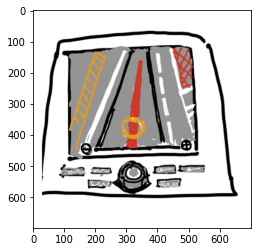

In [ ]:
image1 = plt.imread(totaldata.loc[0,'path'])
plt.imshow(image1)

In [ ]:
plt.figure(figsize=(10,5))

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
from numpy import unique

# summarize dataset
classes = unique(class_list)
total = len(class_list)

In [ ]:
for c in classes:
	n_examples = len(class_list[class_list==c])
	percent = n_examples / total * 100
	print('> Class=%d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class=3 : 595/25503 (2.3%)
> Class=10 : 1893/25503 (7.4%)
> Class=12 : 518/25503 (2.0%)
> Class=15 : 1509/25503 (5.9%)
> Class=20 : 410/25503 (1.6%)
> Class=21 : 410/25503 (1.6%)
> Class=24 : 782/25503 (3.1%)
> Class=25 : 6189/25503 (24.3%)
> Class=27 : 426/25503 (1.7%)
> Class=30 : 364/25503 (1.4%)
> Class=33 : 6206/25503 (24.3%)
> Class=34 : 419/25503 (1.6%)
> Class=39 : 454/25503 (1.8%)
> Class=40 : 180/25503 (0.7%)
> Class=41 : 593/25503 (2.3%)
> Class=44 : 547/25503 (2.1%)
> Class=45 : 631/25503 (2.5%)
> Class=46 : 2214/25503 (8.7%)
> Class=50 : 781/25503 (3.1%)
> Class=52 : 382/25503 (1.5%)


데이터 불균형 문제 확인(6206 / 180)

언더샘플링 - 다수 범주에 속하는 데이터를 제거

데이터 손실 + 분류기 성능 저하

오버샘플링 - 소수 범주를 복제하여 다수가 될 때까지 맞춘다.

- 실제로 수행하는 데 무리는 없으나, 그림에서 우선 사진을 제거해야 함.

# Clustering(Image, Illustration)

In [ ]:
## 그림 그리기 함수

def draw_sample_data(arr, ratio=1):
    n = len(arr)  
    print(n)
    rows = int(np.ceil(n / 10))
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols,
                            figsize=(cols * ratio, rows * ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i * 10 + j < n:
                axs[i, j].imshow(arr[i * 10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

In [ ]:
condition = totaldata['class'].isin(['3', '12', '24', '41', '50'])
clusterdata = totaldata.loc[condition]

forcluster_data = []
clustered_data = pd.DataFrame(columns = ["path", "class"])

In [ ]:
from sklearn.cluster import KMeans

forcluster_data = totaldata[totaldata['class'] == '50']
path_list = forcluster_data['path']
class_list = forcluster_data['class']

images = []
images2 = []

for file in forcluster_data['path']:
    img = Image.open(file)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img)
    images.append(img)

images = np.array(images)
images = images / 255
images = images.reshape(-1, 224, 224, 3)

images2 = images.reshape(len(images), -1)
km = KMeans(n_clusters=5)
km.fit(images2)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


KMeans(n_clusters=5)

In [ ]:
draw_sample_data(images[km.labels_ == 0])
draw_sample_data(images[km.labels_ == 1])
draw_sample_data(images[km.labels_ == 2])
draw_sample_data(images[km.labels_ == 3])
draw_sample_data(images[km.labels_ == 4])

In [ ]:
# clustered_data = pd.concat([clustered_data,forcluster_data[km.labels_ == 3]], axis = 0)

In [ ]:
# clustered_data.to_csv("clustered.csv", encoding = 'euc-kr')

In [ ]:
clustered_data = pd.read_csv("clustered.csv", encoding = "euc-kr")
totaldata.drop(totaldata[totaldata['class'].isin(['3', '12', '24', '41', '50'])].index, inplace = True)

In [ ]:
finaldata = pd.concat([totaldata,clustered_data], axis = 0)
finaldata = finaldata[['path', 'class']]
finaldata = finaldata.rename(columns = {'class' : 'label'})

# AutoEncoder

In [ ]:
image_data = np.load('image224.npy').
class_data = np.load('class224.npy')

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
encoder_input = Input(shape=(224, 224, 3))

# 224 X 224
x = Conv2D(3, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 224 X 224 -> 112 X 112
x = Conv2D(3, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 112 X 112 -> 56 X 56
x = Conv2D(3, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 56 X 56
x = Conv2D(3, 3, padding='same')(x)
x = BatchNormalization()(x)
encoder_output = LeakyReLU()(x)

In [ ]:
encoder = Model(encoder_input, encoder_output)
encoder.summary()

In [ ]:
# Input 2D 
decoder_input = Input(shape=(56, 56, 3))

# 56 X 56 -> 56 X 56
x = Conv2DTranspose(3, 3, strides=1, padding='same')(decoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 56 X 56 -> 112 X 112
x = Conv2DTranspose(3, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 112 X 112 -> 224 X 224
x = Conv2DTranspose(3, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 224 X 224 -> 224 X 224
x = Conv2DTranspose(3, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh')(x)

In [ ]:
decoder = Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 56, 56, 3)]       0         
                                                                 
 conv2d_transpose_53 (Conv2D  (None, 56, 56, 3)        84        
 Transpose)                                                      
                                                                 
 batch_normalization_84 (Bat  (None, 56, 56, 3)        12        
 chNormalization)                                                
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 56, 56, 3)         0         
                                                                 
 conv2d_transpose_54 (Conv2D  (None, 112, 112, 3)      84        
 Transpose)                                                      
                                                          

In [ ]:
encoder_in = Input(shape=(224, 224, 3))
x = encoder(encoder_in)
decoder_out = decoder(x)
auto_encoder = Model(encoder_in, decoder_out)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

idg = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
idg2 = ImageDataGenerator(rescale = 1./255)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
finaldata = finaldata.astype({'label' : 'int64'})
X_train, X_test, y_train, y_test = train_test_split(finaldata, finaldata['label'])

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)
X_under, y_under = undersample.fit_resample(X_under, y_under)
X_under, y_under = undersample.fit_resample(X_under, y_under)
X_under, y_under = undersample.fit_resample(X_under, y_under)

In [ ]:
X_train = X_train.astype({'label' : 'str'})
X_test = X_test.astype({'label' : 'str'})

train_data_generator = idg.flow_from_dataframe(X_train, x_col = "path", y_col = "label", color_mode='rgb',
                                                target_size = (224, 224), class_mode='input', batch_size=64, shuffle=True)
validation_data_generator = idg2.flow_from_dataframe(X_test, x_col = "path", y_col = "label", color_mode='rgb',
                                                target_size = (224, 224), class_mode='input', batch_size=64, shuffle=True)

Found 17882 validated image filenames.
Found 5961 validated image filenames.


In [ ]:
BATCH_SIZE = 64
EPOCH = 300

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


filename = 'AutoEncoder_checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             
                             monitor='loss',   
                             verbose=1,            # 로그 출력
                             save_best_only=True,  # best 값만 저장
                             mode='auto'           # 자동으로 best 탐색
                            )

earlystopping = EarlyStopping(monitor='loss',  
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )
reduceLR = ReduceLROnPlateau(monitor='loss',  
                             factor=0.5,          # callback 호출시 학습률 1/2
                             patience=10,         
)

In [ ]:
auto_encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

auto_encoder.fit(train_data_generator, steps_per_epoch = 15, 
                 epochs=EPOCH, batch_size=BATCH_SIZE, 
                 callbacks=[checkpoint, earlystopping, reduceLR])

Epoch 1/300
15/15 [==============================] - ETA: 0s - loss: 0.9130 - accuracy: 0.2248 
Epoch 1: loss did not improve from 0.07574
15/15 [==============================] - 181s 12s/step - loss: 0.9130 - accuracy: 0.2248 - lr: 0.0010
Epoch 2/300
15/15 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.0999 
Epoch 2: loss did not improve from 0.07574
15/15 [==============================] - 160s 11s/step - loss: 0.7489 - accuracy: 0.0999 - lr: 0.0010
Epoch 3/300
15/15 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.0808 
Epoch 3: loss did not improve from 0.07574
15/15 [==============================] - 158s 11s/step - loss: 0.5882 - accuracy: 0.0808 - lr: 0.0010
Epoch 4/300
15/15 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.0757
Epoch 4: loss did not improve from 0.07574
15/15 [==============================] - 140s 9s/step - loss: 0.4362 - accuracy: 0.0757 - lr: 0.0010
Epoch 5/300
15/15 [===================

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 25/300
15/15 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.1004
Epoch 25: loss improved from 0.01638 to 0.01555, saving model to AutoEncoder_checkpoint-epoch-300-batch-64-trial-001.h5
15/15 [==============================] - 56s 4s/step - loss: 0.0155 - accuracy: 0.1004 - lr: 0.0010
Epoch 26/300
15/15 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.1042
Epoch 26: loss improved from 0.01555 to 0.01545, saving model to AutoEncoder_checkpoint-epoch-300-batch-64-trial-001.h5
15/15 [==============================] - 53s 4s/step - loss: 0.0155 - accuracy: 0.1042 - lr: 0.0010
Epoch 27/300
15/15 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.0998
Epoch 27: loss improved from 0.01545 to 0.01476, saving model to AutoEncoder_checkpoint-epoch-300-batch-64-trial-001.h5
15/15 [==============================] - 60s 4s/step - loss: 0.0148 - accuracy: 0.0998 - lr: 0.0010
Epoch 28/300
15/15 [==============================] 

KeyboardInterrupt: ignored

In [ ]:
encoder = Model(inputs = ㅌ_, outputs=encoder2)

latent_vector = encoder.predict(x_test)

NameError: ignored

In [ ]:
encoder.save('encoder.h5')

# Classification with 10-Fold Cross Validation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import *

skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
idg = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)
idg2 = ImageDataGenerator(rescale = 1./255)

In [ ]:
totaldata = totaldata.astype({'label' : 'str'})

for train_index, test_index in skf.split(totaldata, totaldata['label']):
 
    training_set = totaldata.iloc[train_index]
    validation_set = totaldata.iloc[test_index]

    undersample = RandomUnderSampler(sampling_strategy='majority')
    X_under, y_under = undersample.fit_resample(training_set, training_set['label'])
    X_under, y_under = undersample.fit_resample(X_under, y_under)
    X_under, y_under = undersample.fit_resample(X_under, y_under)
    X_under, y_under = undersample.fit_resample(X_under, y_under)

    resampled_training_set = X_under

    train_data_generator = idg.flow_from_dataframe(resampled_training_set, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size=64, shuffle=True)
    valid_data_generator = idg.flow_from_dataframe(validation_set, x_col = "path", y_col = "label", color_mode='rgb',
                                                   target_size = (224, 224), class_mode='categorical', batch_size=64, shuffle=True)




In [ ]:
# 잘 됐는지 확인

from numpy import unique

classes = unique(y_under)
total = len(y_under)

for c in classes:
	n_examples = len(y_under[y_under==c])
	percent = n_examples / total * 100
	print('> Class=%s : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

# Model Fitting

In [ ]:
# 모델 구축
model = Sequential()
model.add(Convolution2D(32, 3, 3, padding = 'same',
    input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(classnumber))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# 모델 훈련
model.fit(X_train, y_train, batch_size=32, epochs=20)
    
# 모델 평가
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])

# Calculating F1 Score

In [ ]:
pre = model.predict(X_test)

for i,v in enumerate(pre):
    pre_ans = v.argmax()
    ans = y_test[i].argmax()
    dat = X_test[i]
    if ans == pre_ans: continue
    print("[NG]", class_list[pre_ans], "!=", class_list[ans])
    print(v)

In [ ]:
    
    #이미지 출력하기
    fname = "image/error/" + str(i) + "-" + class_list[pre_ans] + \
        "-ne-" + class_list[ans] + ".png"
    dat *= 256
    img = Image.fromarray(np.uint8(dat))
    img.save(fname)

# dd

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

ImportError: ignored

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Define the model
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#-------------------------
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 activation_10 (Activation)  (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 112, 112, 2)       290       
                                                                 
 activation_11 (Activation)  (None, 112, 112, 2)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 2)        0         
 2D)                                                  

In [ ]:
model.fit(
        train_data_generator,
        steps_per_epoch=1000 // BATCH_SIZE,
        epochs=20,
        validation_data=validation_data_generator,
        validation_steps=1000 // BATCH_SIZE)

Epoch 1/20
 2/15 [===>..........................] - ETA: 3:24 - loss: 0.2415

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

idg = ImageDataGenerator(rescale = 1./255, data_format='channels_last', horizontal_flip = True)
idg2 = ImageDataGenerator(rescale = 1./255, data_format='channels_last')

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 
finaldata = finaldata.astype({'label' : 'int64'})
X_train, X_test, y_train, y_test = train_test_split(finaldata, finaldata['label'])

In [ ]:
X_train = X_train.astype({'label' : 'str'})
X_test = X_test.astype({'label' : 'str'})

train_data_generator = idg.flow_from_dataframe(X_train, x_col = "path", y_col = "label", color_mode='rgb',
                                                target_size = (224, 224), class_mode='input', batch_size=64, shuffle=True)
validation_data_generator = idg2.flow_from_dataframe(X_test, x_col = "path", y_col = "label", color_mode='rgb',
                                                target_size = (224, 224), class_mode='input', batch_size=64, shuffle=True)

Found 17882 validated image filenames.
Found 5961 validated image filenames.
